In [1]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 199 kB/s eta 0:00:01
     |████████████████████████████████| 23.9 MB 71.9 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import missingno as msno
import itertools
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [3]:
rc('font', family='NanumGothic')
rc('axes', unicode_minus=False)
sns.set_style("darkgrid")
sns.set_palette("muted")

In [4]:
file_root_path = os.getenv('HOME')+'/aiffel/Git_Project/PayMeBack/input'
os.listdir(file_root_path)

['test.csv', 'sample_submission.csv', 'train.csv']

In [5]:
train_df = pd.read_csv(file_root_path+'/train.csv')
test_df = pd.read_csv(file_root_path+'/test.csv')
sample_submission_df = pd.read_csv(file_root_path+'/sample_submission.csv')

## 데이터 변수 설명
https://www.dacon.io/competitions/official/235713/talkboard/402821/    
* index
* gender: 성별
    ['M', 'F']
* car: 차량 소유 여부
    ['Y','N']  -> 소유 여부를 0, 1로 바꿔줘야 한다.
* reality: 부동산 소유 여부
    ['Y','N']  -> 소유 여부를 0, 1로 바꿔줘야 한다.
* child_num: 자녀 수
* income_total: 연간 소득 -> 연속형 데이터로 범주화가 필요하다.
* income_type: 소득 분류 -> 연간 소득과 소득 분류가 관계가 있는지 확인해봐야겠다.
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
* edu_type: 교육 수준 -> 연간 소득과 교육 수준의 관계를 확인해야 겠다.
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
    고등교육, 중등교육, 고등교육 자퇴, 중등교육보다 낮음, 학사학위 -> 교육수준에 따른 서열이 존재할 것이라 예상
    
* family_type: 결혼 여부
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

* house_type: 생활 방식
    ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']

* DAYS_BIRTH: 출생일
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미    
    나이로 변환해서 사용가능

* DAYS_EMPLOYED: 업무 시작일
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미    
    양수 값은 고용되지 않은 상태를 의미함

* FLAG_MOBIL: 핸드폰 소유 여부
    [0,1]

* work_phone: 업무용 전화 소유 여부
    [0,1]

* phone: 전화 소유 여부
    [0,1]

* email: 이메일 소유 여부

* occyp_type: 직업 유형													
    연간 소득과 교육수준과 비교할 수 있을 것 같다.

* family_size: 가족 규모
* begin_month: 신용카드 발급 월
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
    => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

# 1. 데이터 살펴보기

In [6]:
train_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [7]:
test_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [8]:
sample_submission_df.head()

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0


In [9]:
print(f'train shape: {train_df.shape}')
print(f'test shape: {test_df.shape}')
print(f'submission shaep: {sample_submission_df.shape}')

train shape: (26457, 20)
test shape: (10000, 19)
submission shaep: (10000, 4)


# EDA

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

occyp_type에 결측치가 존재한다.

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

test에서도 동일하게 occyp_type에 결측치가 존재한다.

## 신용 등급 비율

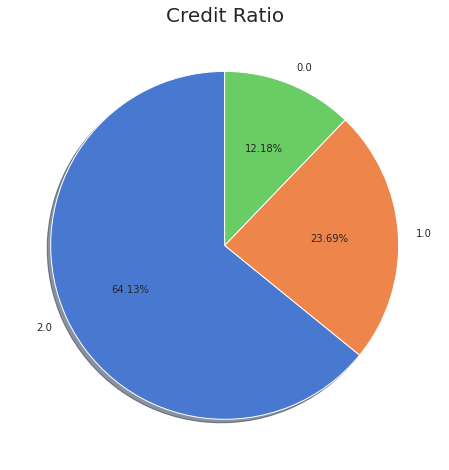

In [12]:
plt.subplots(figsize = (8,8))
plt.pie(train_df['credit'].value_counts(), labels = train_df['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Credit Ratio', size=20)
plt.show()

값이 낮을 수록 높은 신용등급을 가진 사용자를 의미한다. 따라서 낮은 신용등급을 가진 사용자가 많다는 것을 알 수 있다.

## 신용 등급에 따른 성비

<AxesSubplot:xlabel='credit', ylabel='count'>

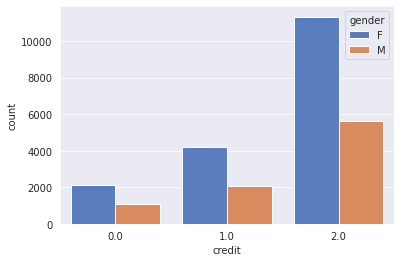

In [13]:
sns.countplot(data=train_df, x='credit', hue='gender')

모든 등급에서 남성보다 여성이 많았고,     
위의 pie chart에서 본 것 과 같이 사용자 중 신용 등급이 높은 사람보다 낮은 사람이 많다는 것을 알 수 있다.

## 신용 등급에 따른 차량 소유 여부

<AxesSubplot:xlabel='credit', ylabel='count'>

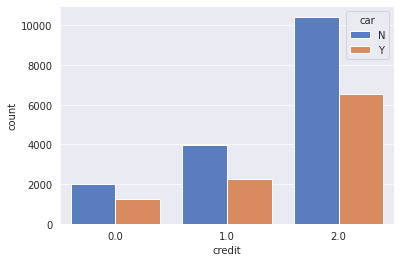

In [14]:
sns.countplot(data=train_df, x='credit', hue='car')

모든 등급에서 차를 소유하지 않은 사람이 더 많았다.

## 신용 등급에 따른 부동산 소유 여부

<AxesSubplot:xlabel='credit', ylabel='count'>

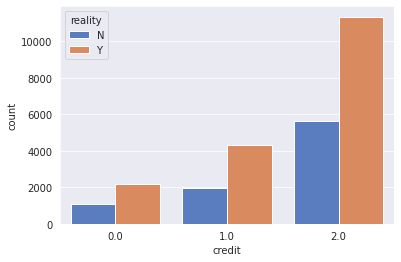

In [15]:
sns.countplot(data=train_df, x='credit', hue='reality')

모든 등급에서 부동산을 소유한 사람이 더 많았다.

## 신용 등급에 따른 소득 분류의 차이

In [16]:
income_type_ratio_by_credit = train_df.groupby(['credit', 'income_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','income_type' : 'income_type', 'index':'count'})
income_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
income_type_ratio_by_credit

,credit,income_type,count
2,0.0,State servant,265
1,0.0,Pensioner,536
0,0.0,Commercial associate,782
3,0.0,Working,1639
7,1.0,Student,3
6,1.0,State servant,489
5,1.0,Pensioner,1084
4,1.0,Commercial associate,1344
8,1.0,Working,3347
12,2.0,Student,4


<AxesSubplot:xlabel='credit', ylabel='count'>

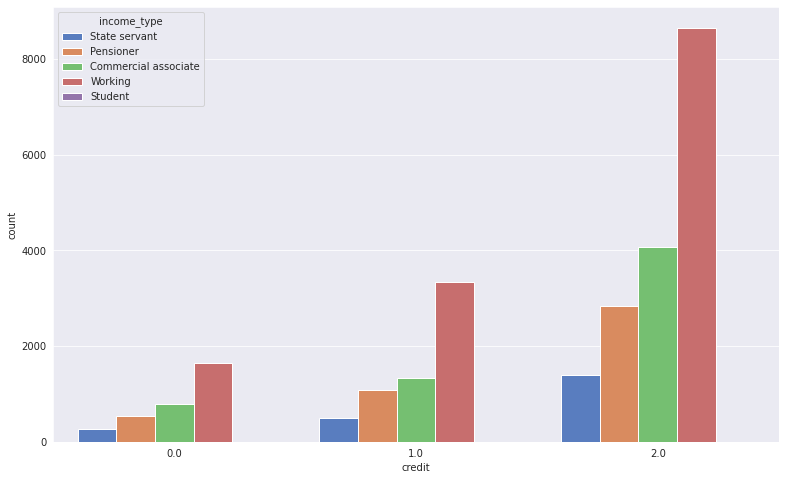

In [17]:
plt.figure(figsize = (13,8))
sns.barplot(data=income_type_ratio_by_credit, x='credit', y='count', hue='income_type')

student부분이 잘 안보여서 student만 따로 시각화하였다.

<AxesSubplot:xlabel='credit', ylabel='count'>

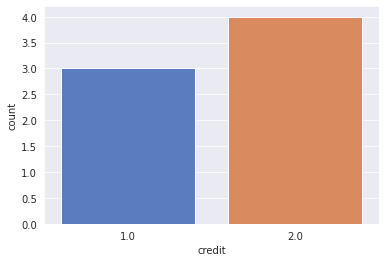

In [18]:
temp = income_type_ratio_by_credit.loc[income_type_ratio_by_credit['income_type'] == 'Student']
sns.barplot(data=temp, x='credit', y='count')

학생은 0 신용등급을 가진 사람이 없고, 낮은 등급에도 1에는 3명, 2에는 4명 정도로 적게 있는 것을 알 수 있다.    
등급에 상관없이 사용자가 많은 직업군은    
State servant < Pensioner < Commercial associate < Working 이다.

## 신용 등급에 따른 교육 수준

In [19]:
edu_type_ratio_by_credit = train_df.groupby(['credit', 'edu_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','edu_type' : 'edu_type', 'index':'count'})
edu_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
edu_type_ratio_by_credit

,credit,edu_type,count
0,0.0,Academic degree,2
3,0.0,Lower secondary,28
2,0.0,Incomplete higher,114
1,0.0,Higher education,909
4,0.0,Secondary / secondary special,2169
5,1.0,Academic degree,7
8,1.0,Lower secondary,59
7,1.0,Incomplete higher,246
6,1.0,Higher education,1751
9,1.0,Secondary / secondary special,4204


<AxesSubplot:xlabel='edu_type', ylabel='count'>

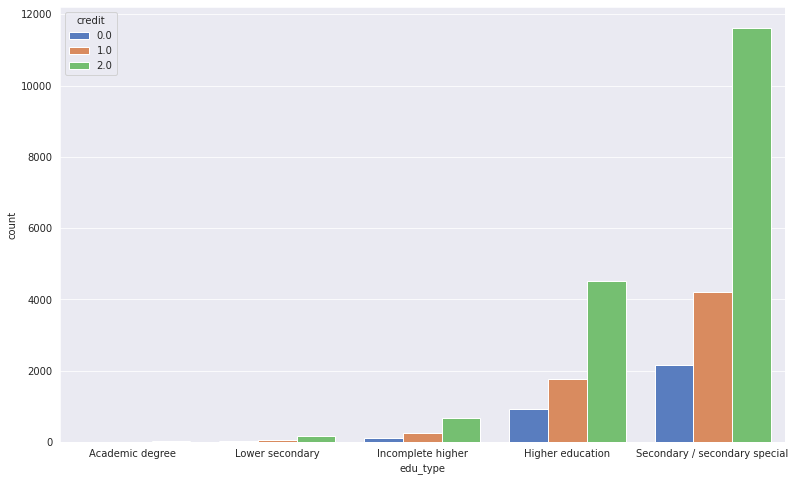

In [20]:
plt.figure(figsize = (13,8))
sns.barplot(data=edu_type_ratio_by_credit, x='edu_type', y='count', hue='credit')

모든 등급에 상관 없이 교육 수준의 순위가 같았다.    
Academic degree < Lower secondary < Incomplete higher < Higher education < Secondary

## 신용 등급에 따른 결혼 여부

In [21]:
family_type_ratio_by_credit = train_df.groupby(['credit', 'family_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','family_type' : 'family_type', 'index':'count'})
family_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
family_type_ratio_by_credit

,credit,family_type,count
4,0.0,Widow,126
2,0.0,Separated,193
0,0.0,Civil marriage,288
3,0.0,Single / not married,402
1,0.0,Married,2213
9,1.0,Widow,299
7,1.0,Separated,349
5,1.0,Civil marriage,539
8,1.0,Single / not married,940
6,1.0,Married,4140


<AxesSubplot:xlabel='family_type', ylabel='count'>

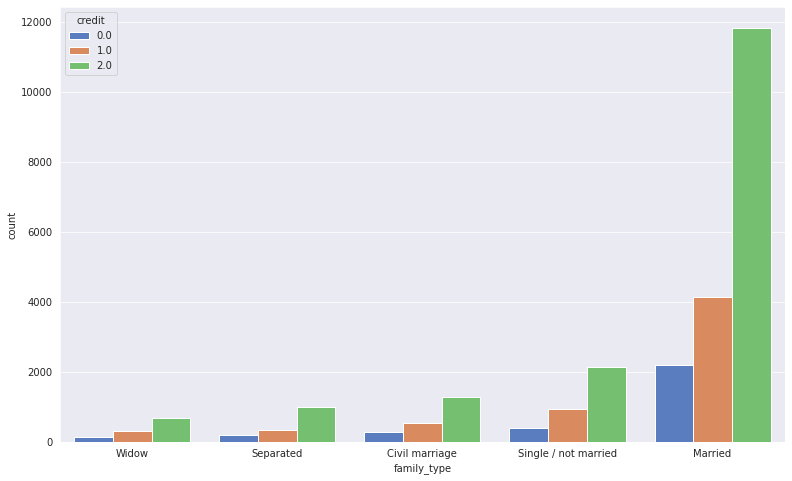

In [22]:
plt.figure(figsize = (13,8))
sns.barplot(data=family_type_ratio_by_credit, x='family_type', y='count', hue='credit')

신용 등급에 상관 없이 가족 형태에 따른 순위는 동일했다.    
또, 모든 등급과 상관없이 결혼한 사람들이 상대적으로 많이 존재한다.

## 신용 등급에 따른 가족 수 차이

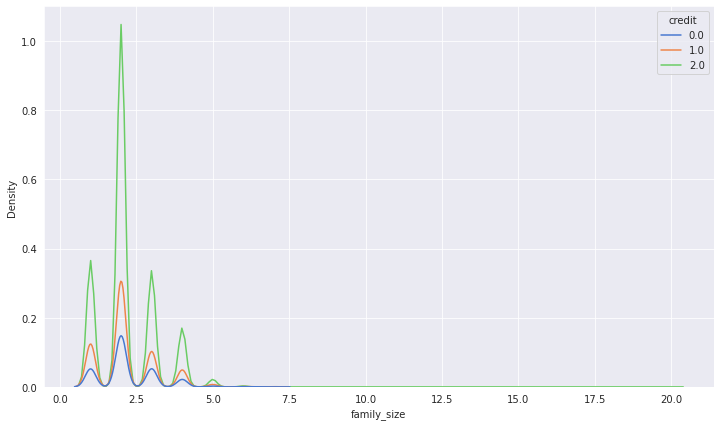

In [23]:
fig, ax= plt.subplots(figsize=(12,7))
sns.kdeplot(data=train_df, x='family_size', hue='credit', palette='muted', ax=ax)
plt.show()

가족수가 두명인 사람들이 많았다. 위 그래프에서 결혼한 사람이 많은 것에 영향을 받았을 거라 추측한다.

## 신용 등급에 따른 자녀 수의 차이

In [24]:
train_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


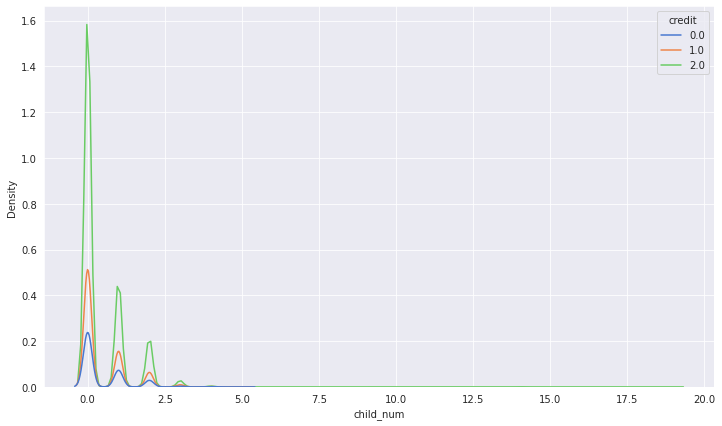

In [25]:
fig, ax= plt.subplots(figsize=(12,7))
sns.kdeplot(data=train_df, x='child_num', hue='credit', palette='muted')
plt.show()

자녀 수도 신용 등급에 따라 차이가 있어보이진 않는다.    
그래프 형태로 보아 범주형 데이터로 바꿔야 할 것 같다.    

위의 가족수와 결혼 여부 시각화 결과를 보고 추측하는 바로는 결혼은 했지만 아이를 낳지 않은 가족이 많다는 것을 알 수 있다.

## 신용 등급에 따른 생활 방식 차이

In [26]:
house_type_ratio_by_credit = train_df.groupby(['credit', 'house_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','house_type' : 'house_type', 'index':'count'})
house_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
house_type_ratio_by_credit

,credit,house_type,count
0,0.0,Co-op apartment,14
3,0.0,Office apartment,24
4,0.0,Rented apartment,50
2,0.0,Municipal apartment,110
5,0.0,With parents,151
1,0.0,House / apartment,2873
6,1.0,Co-op apartment,30
9,1.0,Office apartment,48
10,1.0,Rented apartment,147
8,1.0,Municipal apartment,160


<AxesSubplot:xlabel='house_type', ylabel='count'>

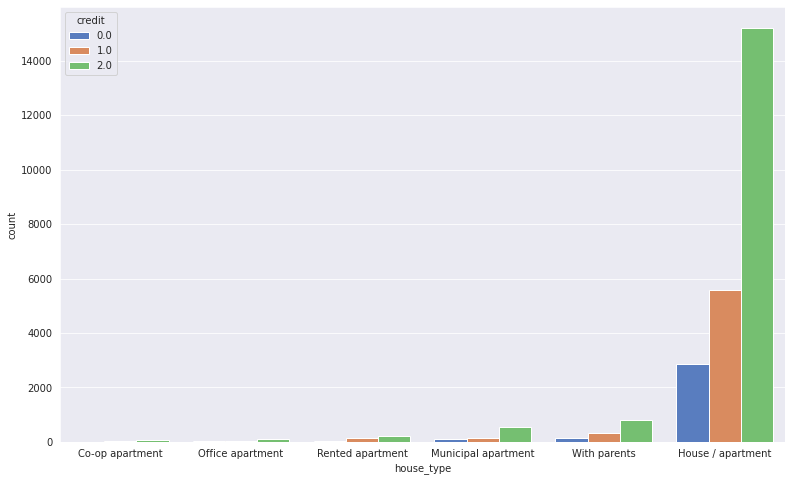

In [27]:
plt.figure(figsize = (13,8))
sns.barplot(data=house_type_ratio_by_credit, x='house_type', y='count', hue='credit')

신용 등급에 상관없이 생활 방식은 순위가 동일했다.    
상대적으로 많이 존재하는 생활 방식은 House/apartment이다.

## 신용등급에 따른 휴대폰 소지여부

Text(0.5, 1.0, 'credit=2')

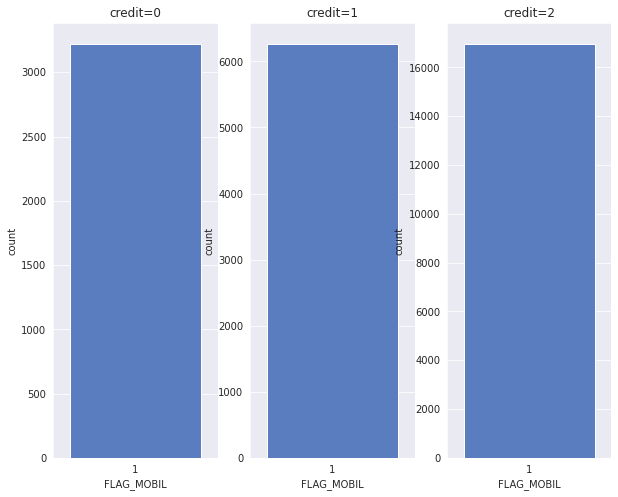

In [28]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='FLAG_MOBIL', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='FLAG_MOBIL', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='FLAG_MOBIL', ax=axes[2])
axes[2].set_title('credit=2')

In [29]:
print('휴대전화를 가지고 있는 비율:', (train_df.FLAG_MOBIL.sum()/len(train_df))*100)

휴대전화를 가지고 있는 비율: 100.0


모든 사람이 휴대전화를 가지고 있다는 것을 알 수 있다.    
추후 이부분은 삭제해도 무방할 데이터라고 생각한다.

##  신용 등급에 따른 업무용 전화 소지여부

Text(0.5, 1.0, 'credit=2')

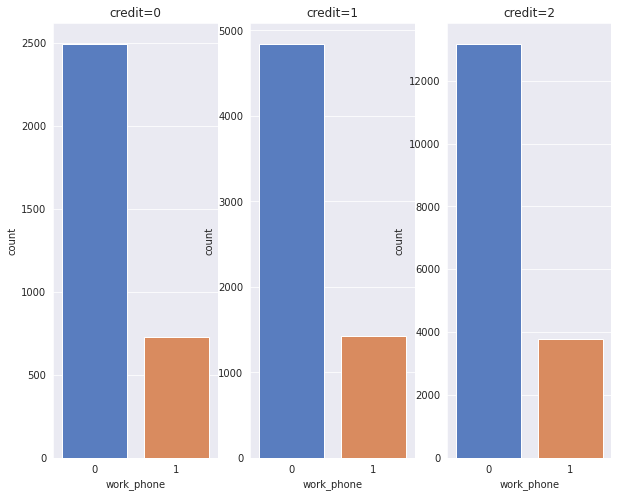

In [30]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='work_phone', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='work_phone', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='work_phone', ax=axes[2])
axes[2].set_title('credit=2')

## 신용 등급에 따른 전화 소지여부

Text(0.5, 1.0, 'credit=2')

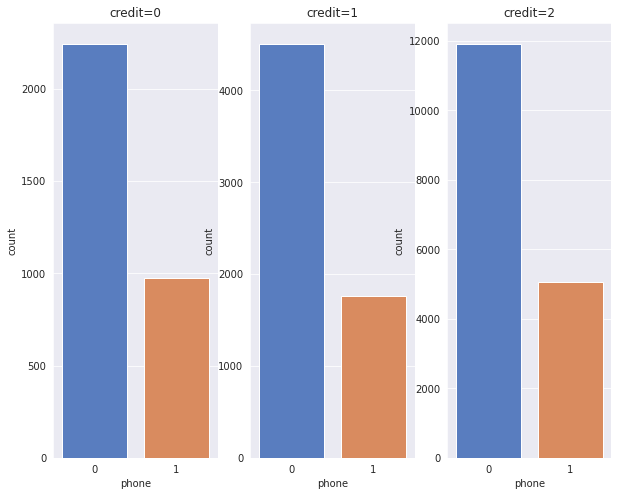

In [31]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='phone', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='phone', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='phone', ax=axes[2])
axes[2].set_title('credit=2')

## 신용 등급에 따른 이메일 소지여부

Text(0.5, 1.0, 'credit=2')

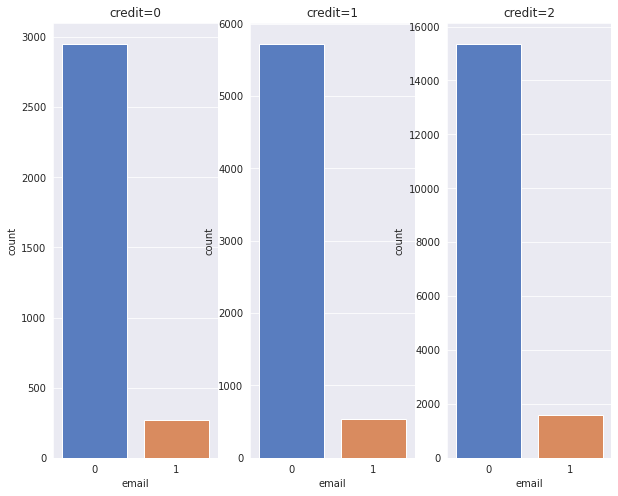

In [32]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='email', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='email', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='email', ax=axes[2])
axes[2].set_title('credit=2')

소지여부 시각화를 종합해서 분석해보면 등급에 상관없이 업무용 전화, 전화, 이메일을 소지하지 않은 사람이 많았다.

## 신용 등급에 따른 직업 유형

<AxesSubplot:>

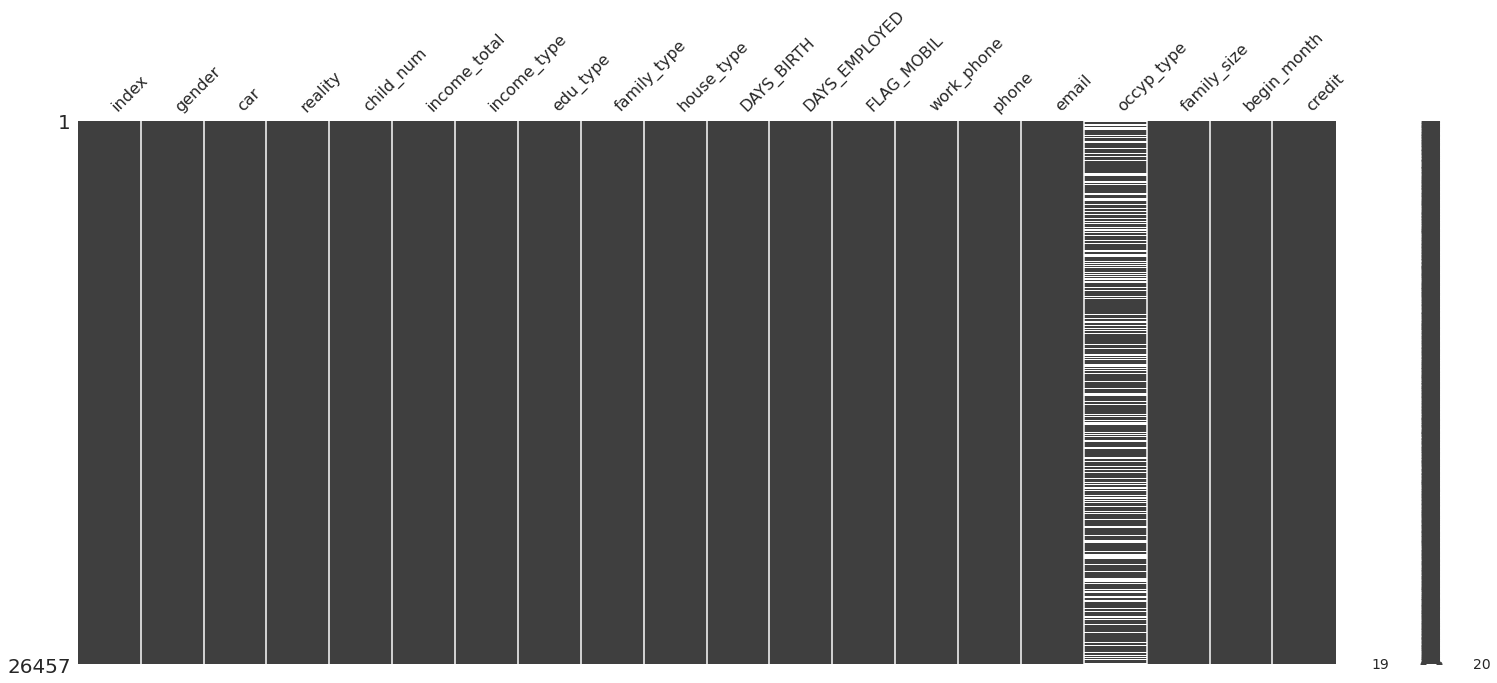

In [33]:
msno.matrix(train_df)

occyp_type가 결측치가 존재하므로 빈 값을 no job으로 채워서 시각화한다.

In [34]:
temp= train_df.copy()
temp.occyp_type.fillna('no_job', inplace=True)

Text(0.5, 1.0, 'credit=2')

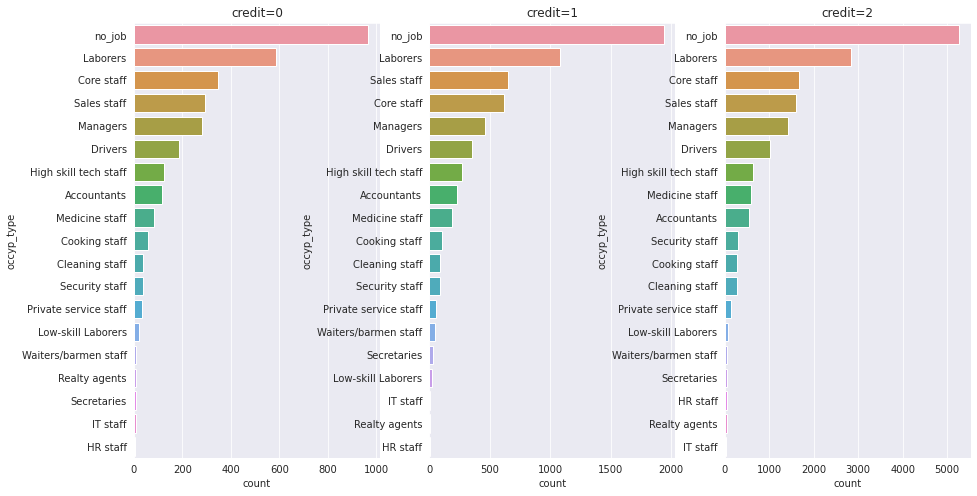

In [35]:
flg, axes = plt.subplots(1,3,figsize=(15,8))

sns.countplot(data=temp.loc[temp.credit==0], y='occyp_type', order=temp.loc[temp.credit==0,'occyp_type'].value_counts().index, ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=temp.loc[temp.credit==1], y='occyp_type', order=temp.loc[temp.credit==1,'occyp_type'].value_counts().index, ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=temp.loc[temp.credit==2], y='occyp_type', order=temp.loc[temp.credit==2,'occyp_type'].value_counts().index, ax=axes[2])
axes[2].set_title('credit=2')

직업 유형은 신용등급에 따라 미세하게 차이가 난다.

## 신용 등급에 따른 연간 소득 차이

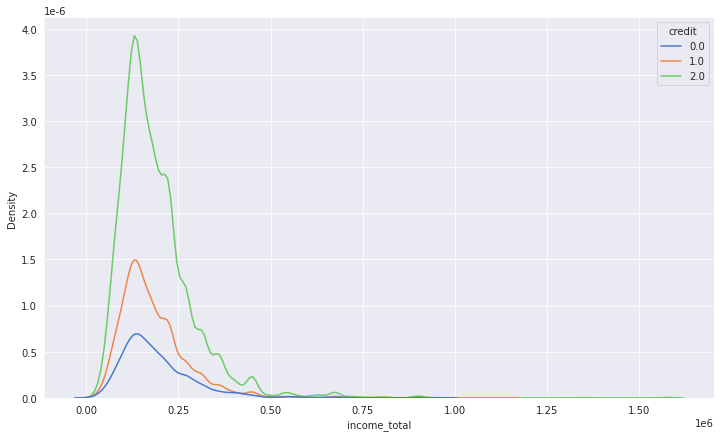

In [36]:
fig, ax= plt.subplots(figsize=(12,7))
sns.kdeplot(data=train_df, x='income_total', hue='credit', palette='muted', ax=ax)
plt.show()

신용 등급에 따라 연간 소득의 차이는 없어보인다.

## 신용 등급에 따른 연령대 차이

In [37]:
temp=train_df.copy()
temp['age'] = -temp['DAYS_BIRTH']//365

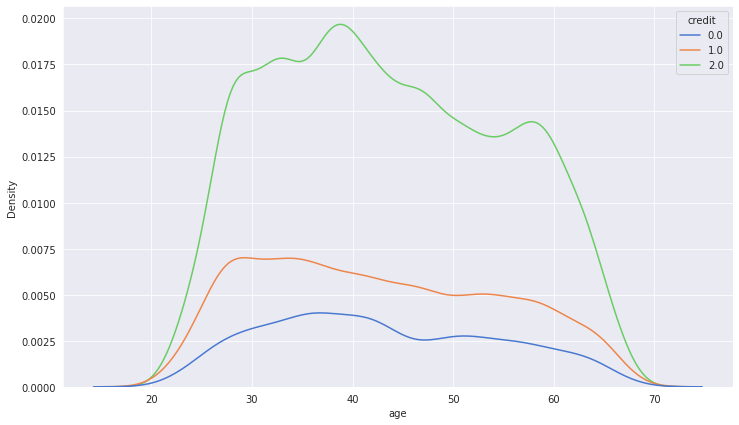

In [38]:
fig, ax= plt.subplots(figsize=(12,7))
sns.kdeplot(data=temp, x='age', hue='credit', palette='muted', ax=ax)
plt.show()

등급별로 차이는 없지만 20\~30대와 60대의 비율이 낮다.    
아무래도 20\~30대는 학생과 사회 초년생이 많고, 60대 이상은 경제활동이 적어진다고 예측할 수 있다.

## 신용 등급에 따른 업무 기간의 차이
DAYS_EMPLOYED는 무직인 경우이므로 0으로 값을 대체한다.

In [39]:
temp=train_df.copy()
temp.loc[temp['DAYS_EMPLOYED'] >= 0, 'DAYS_EMPLOYED'] = 0
temp['carrer_year'] = round(-temp['DAYS_EMPLOYED']/365,2)

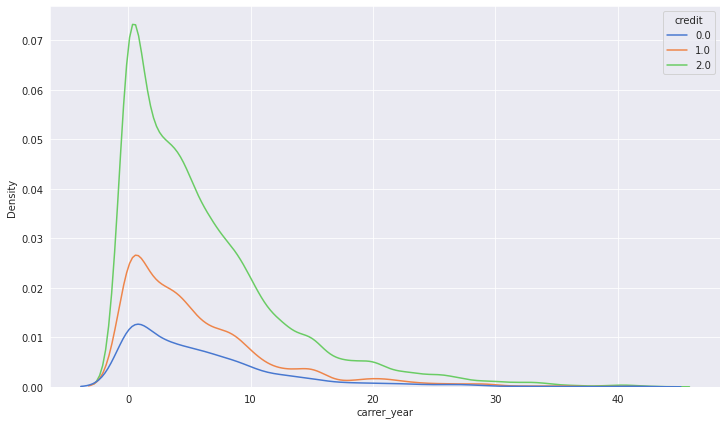

In [40]:
fig, ax= plt.subplots(figsize=(12,7))
sns.kdeplot(data=temp, x='carrer_year', hue='credit', palette='muted', ax=ax)
plt.show()

 신용 등급별로 차이는 없으나 무직인 사람이 비율이 가장 많고, 경력이 많아질수록 비율은 떨어진다.

## 신용 등급에 따른 카드 발급 기간의 차이
Month를 Year로 바꿔서 시각화하였다.

In [41]:
temp=train_df.copy()
temp['begin_year'] = round(-temp['begin_month']/12, 2)

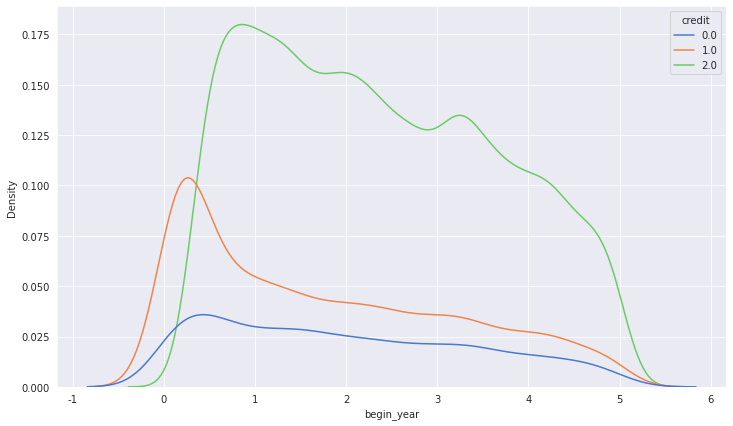

In [42]:
fig, ax= plt.subplots(figsize=(12,7))
sns.kdeplot(data=temp, x='begin_year', hue='credit', palette='muted', ax=ax)
plt.show()

만든지 1년 이하의 사용자들이 많은 것을 볼 수 있다.

## 마이너스 값을 양수값으로 변환 후 시각화
DAYS_BIRTH, DAYS_EMPLOYED, begin_month    
DAYS_BIRTH와 DAYS_EMPLOYED는 일수이므로 365를 나눠 년수로 바꿔준다.

In [43]:
def convert_days_birth_to_year(data):
    return -data//365

def convert_days_employed_to_year(data):
    return round(-data/365,2)

def convert_month_begin_to_year(data):
    return round(-data/12, 2)

In [44]:
train_df['age'] = convert_days_birth_to_year(train_df['DAYS_BIRTH'])
test_df['age'] = convert_days_birth_to_year(test_df['DAYS_BIRTH'])

DAYS_EMPLOYED의 양수값은 고용되지 않은 것이므로 0으로 바꿔준다.

In [45]:
train_df.loc[train_df['DAYS_EMPLOYED'] >= 0, 'DAYS_EMPLOYED'] = 0

In [46]:
train_df['carrer_year'] = convert_days_employed_to_year(train_df['DAYS_EMPLOYED'])
test_df['carrer_year'] = convert_days_employed_to_year(test_df['DAYS_EMPLOYED'])

In [47]:
train_df['begin_year'] = convert_month_begin_to_year(train_df['begin_month'])
test_df['begin_year'] = convert_month_begin_to_year(test_df['begin_month'])

In [48]:
train_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,carrer_year,begin_year
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,...,0,0,0,NaN,2.0,-6.0,1.0,38,12.90,0.50
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,0,0,1,Laborers,3.0,-5.0,1.0,31,4.22,0.42
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,...,0,1,0,Managers,2.0,-22.0,2.0,52,12.15,1.83
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,1,0,Sales staff,2.0,-37.0,0.0,41,5.73,3.08
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,...,0,0,0,Managers,2.0,-26.0,2.0,41,5.77,2.17


# 데이터 전처리

## 1. 결측치 처리

In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

<AxesSubplot:>

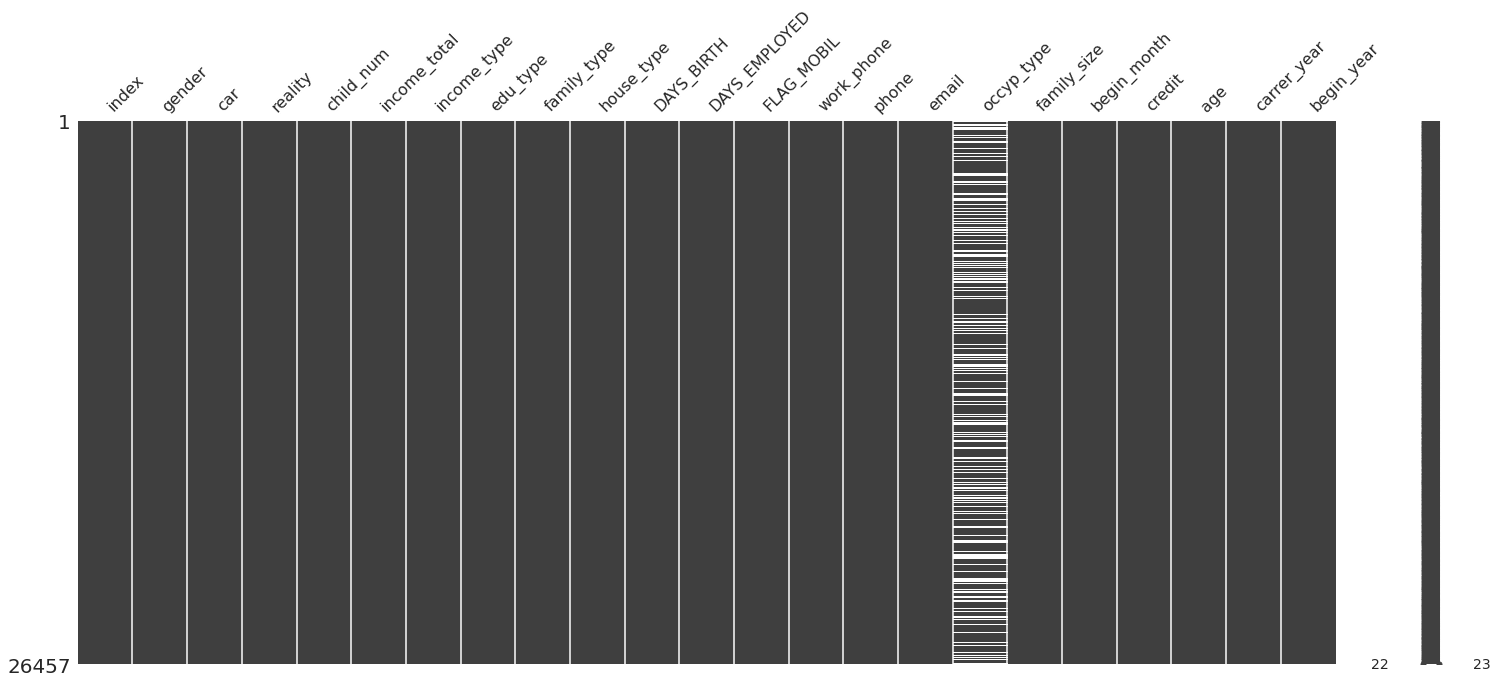

In [50]:
msno.matrix(train_df)

In [51]:
# occyp_type이 null인 비율
print(round(train_df.occyp_type.isnull().sum()/len(train_df), 2)*100,'%')

31.0 %


null 값을 백수라고 가정하고 no_job으로 채운다.

In [52]:
train_df.occyp_type.fillna('no jobs', inplace=True)
test_df.occyp_type.fillna('no jobs', inplace=True)

<AxesSubplot:>

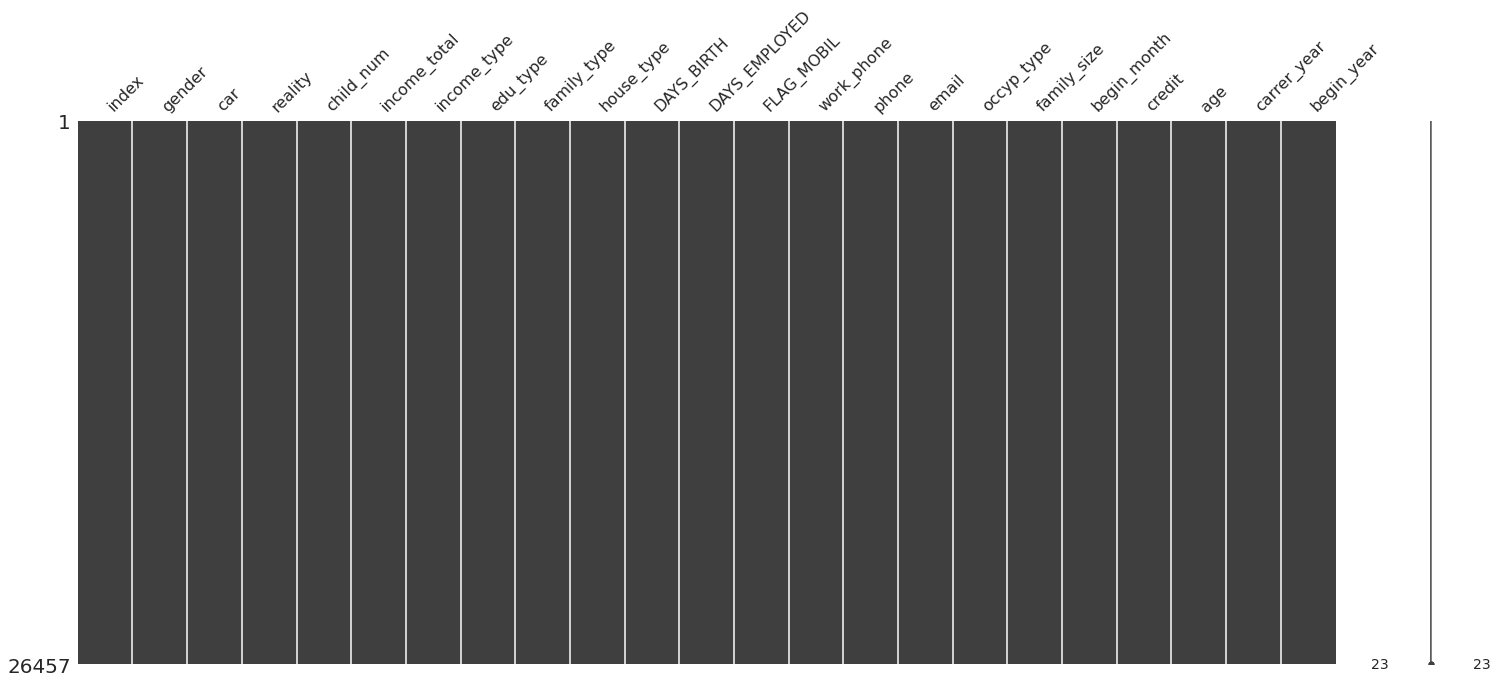

In [53]:
# 확인
msno.matrix(train_df)

## 2. 이진 카테고리 데이터를 숫자형으로 변환
gender, car, reality는 이진 카테고리이므로 숫자형으로 변환한다.
(이진 카테고리: 카테고리 값이 두개밖에 없다.)

In [54]:
# 정말 이진 카테고리값인지 확인한다.
print('gender: ', train_df['gender'].unique())
print('car: ', train_df['car'].unique())
print('reality: ', train_df['reality'].unique())

gender:  ['F' 'M']
car:  ['N' 'Y']
reality:  ['N' 'Y']


In [55]:
# gender
train_df['gender'] = train_df['gender'].replace(['F', 'M'], [0,1])
test_df['gender'] = test_df['gender'].replace(['F', 'M'], [0,1])

# car
train_df['car'] = train_df['car'].replace(['N', 'Y'], [0,1])
test_df['car'] = test_df['car'].replace(['N', 'Y'], [0,1])

# reality
train_df['reality'] = train_df['reality'].replace(['N', 'Y'], [0,1])
test_df['reality'] = test_df['reality'].replace(['N', 'Y'], [0,1])

## 3. 연속형 변수를 순서형 변수로 변환

### 1) child_num
자녀 수는 범주형 변수로 봐도 되지만 시각화해본 결과 범위가 커서 순서형으로 나누려고 한다.    

<AxesSubplot:>

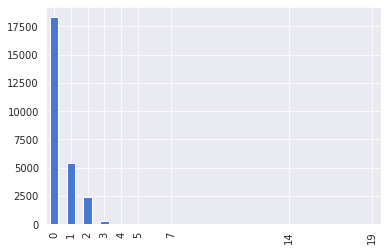

In [56]:
train_df['child_num'].value_counts(sort=False).plot.bar()

In [57]:
round(train_df.loc[train_df['child_num']>=3, 'index'].count()/len(train_df),2)*100

1.0

자녀수가 3명 이상인 경우가 1%밖에 안되므로 3명 이상을 하나의 범주로 나누려고 한다.
따라서 나눠지는 자녀수 범주는 0, 1, 2, 3이다.

In [58]:
train_df.loc[train_df['child_num']>=3, 'child_num'] = 3
test_df.loc[test_df['child_num']>=3, 'child_num'] = 3

### 2) income_total
income_total은 연속형 변수이므로 범주를 나누어 순서형 변수로 바꾸려고 한다.

In [59]:
train_df.income_total.describe()

count    2.645700e+04
mean     1.873065e+05
std      1.018784e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: income_total, dtype: float64

일단 숫자를 보기 힘들기 때문에 10000으로 나눠준다.

In [60]:
train_df['income_total'] = train_df['income_total']/10000 
test_df['income_total'] = test_df['income_total']/10000

In [61]:
train_df.income_total.describe()

count    26457.000000
mean        18.730652
std         10.187837
min          2.700000
25%         12.150000
50%         15.750000
75%         22.500000
max        157.500000
Name: income_total, dtype: float64

<AxesSubplot:xlabel='income_total', ylabel='Density'>

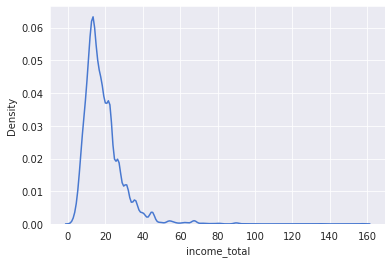

In [62]:
sns.kdeplot(data=train_df, x='income_total')

In [63]:
train_df['income_total_range'] = pd.qcut(train_df['income_total'], 8)
test_df['income_total_range'] = pd.qcut(test_df['income_total'], 8)

In [64]:
train_df.groupby(['income_total_range'])['index'].count().to_frame()

,index
income_total_range,
"(2.6990000000000003, 9.45]",3328
"(9.45, 12.15]",3423
"(12.15, 13.5]",3727
"(13.5, 15.75]",2958
"(15.75, 19.8]",3147
"(19.8, 22.5]",4187
"(22.5, 28.8]",2388
"(28.8, 157.5]",3299


In [65]:
def income_to_range(df):    
    df['income_cat']=0
    df.loc[df['income_total']<=9.45,'income_cat']=0
    df.loc[(df['income_total']>9.45)&(df['income_total']<=12.15),'income_cat']=1
    df.loc[(df['income_total']>12.15)&(df['income_total']<=13.5),'income_cat']=2
    df.loc[(df['income_total']>13.5)&(df['income_total']<=15.75),'income_cat']=3
    df.loc[(df['income_total']>15.75)&(df['income_total']<=19.8),'income_cat']=4
    df.loc[(df['income_total']>19.8)&(df['income_total']<=22.5),'income_cat']=5
    df.loc[(df['income_total']>22.5)&(df['income_total']<=28.8),'income_cat']=6
    df.loc[(df['income_total']>28.8),'income_cat']=7

In [66]:
income_to_range(train_df)
income_to_range(test_df)

In [67]:
train_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,email,occyp_type,family_size,begin_month,credit,age,carrer_year,begin_year,income_total_range,income_cat
0,0,0,0,0,0,20.25,Commercial associate,Higher education,Married,Municipal apartment,...,0,no jobs,2.0,-6.0,1.0,38,12.90,0.50,"(19.8, 22.5]",5
1,1,0,0,1,1,24.75,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,1,Laborers,3.0,-5.0,1.0,31,4.22,0.42,"(22.5, 28.8]",6
2,2,1,1,1,0,45.00,Working,Higher education,Married,House / apartment,...,0,Managers,2.0,-22.0,2.0,52,12.15,1.83,"(28.8, 157.5]",7
3,3,0,0,1,0,20.25,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,Sales staff,2.0,-37.0,0.0,41,5.73,3.08,"(19.8, 22.5]",5
4,4,0,1,1,0,15.75,State servant,Higher education,Married,House / apartment,...,0,Managers,2.0,-26.0,2.0,41,5.77,2.17,"(13.5, 15.75]",3


<BarContainer object of 8 artists>

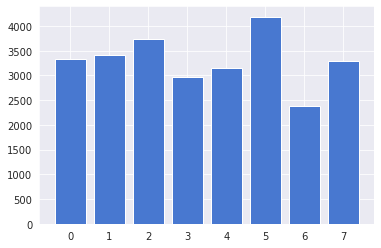

In [68]:
income_group = train_df.groupby('income_cat')['index'].count().to_frame().reset_index()
income_group.rename(columns={'index':'count'}, inplace=True)
plt.bar(range(8), income_group['count'])

'income_cat'를 생성했으니 income_total, income_total_range는 삭제한다.

In [69]:
train_df.drop(['income_total', 'income_total_range'], axis=1, inplace=True)
test_df.drop(['income_total', 'income_total_range'], axis=1, inplace=True)

In [70]:
train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,phone,email,occyp_type,family_size,begin_month,credit,age,carrer_year,begin_year,income_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,...,0,0,no jobs,2.0,-6.0,1.0,38,12.90,0.50,5
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,...,0,1,Laborers,3.0,-5.0,1.0,31,4.22,0.42,6
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,...,1,0,Managers,2.0,-22.0,2.0,52,12.15,1.83,7
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,...,1,0,Sales staff,2.0,-37.0,0.0,41,5.73,3.08,5
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,...,0,0,Managers,2.0,-26.0,2.0,41,5.77,2.17,3


In [71]:
test_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,work_phone,phone,email,occyp_type,family_size,begin_month,age,carrer_year,begin_year,income_cat
0,26457,1,1,0,0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,...,0,1,0,no jobs,2.0,-60.0,60,-1000.67,5.00,1
1,26458,0,0,1,0,State servant,Higher education,Married,House / apartment,-18964,...,0,1,0,Core staff,2.0,-36.0,51,23.76,3.00,2
2,26459,0,0,1,0,Working,Secondary / secondary special,Married,House / apartment,-15887,...,1,1,0,Laborers,2.0,-40.0,43,0.59,3.33,0
3,26460,1,1,0,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,...,1,0,0,Drivers,2.0,-41.0,52,6.93,3.42,1
4,26461,0,1,1,0,State servant,Higher education,Married,House / apartment,-17822,...,1,0,0,Managers,2.0,-8.0,48,25.71,0.67,5


In [72]:
train_df['income_type'].unique()

array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
       'Student'], dtype=object)

## 4. 마이너스 연속형 변수를 구간화
양수로 변환하는 과정은 위에서 진행했다.

#### DAY_BIRTH

In [73]:
train_df.age.describe()

count    26457.000000
mean        43.213478
std         11.513590
min         21.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         68.000000
Name: age, dtype: float64

나이는 10, 20, 30...으로 구간화 시킨다. 최대 나이가 67세이므로 구간화는 0~60으로 한다.

In [74]:
def age_to_range(df):
    df['age_cat']=0
    df.loc[df['age']<10,'age_cat']=0
    df.loc[(df['age']>=10)&(df['age']<20),'age_cat']=1
    df.loc[(df['age']>=20)&(df['age']<30),'age_cat']=2
    df.loc[(df['age']>=30)&(df['age']<40),'age_cat']=3
    df.loc[(df['age']>=40)&(df['age']<50),'age_cat']=4
    df.loc[(df['age']>=50)&(df['age']<60),'age_cat']=5
    df.loc[(df['age']>=60),'age_cat']=6    
    
    
age_to_range(train_df)
age_to_range(test_df)

train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,email,occyp_type,family_size,begin_month,credit,age,carrer_year,begin_year,income_cat,age_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,...,0,no jobs,2.0,-6.0,1.0,38,12.90,0.50,5,3
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,...,1,Laborers,3.0,-5.0,1.0,31,4.22,0.42,6,3
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,...,0,Managers,2.0,-22.0,2.0,52,12.15,1.83,7,5
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,...,0,Sales staff,2.0,-37.0,0.0,41,5.73,3.08,5,4
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,...,0,Managers,2.0,-26.0,2.0,41,5.77,2.17,3,4


#### DAYS_EMPLOYED

In [75]:
train_df.carrer_year.describe()

count    26457.000000
mean         6.023467
std          6.493533
min          0.000000
25%          1.120000
50%          4.220000
75%          8.640000
max         43.050000
Name: carrer_year, dtype: float64

경력도 10년 단위로 나눠서 구간화를 시켜준다.

In [76]:
def carrer_year_to_range(df):
    df['carrer_year_cat']=0
    df.loc[df['carrer_year']<=10,'carrer_year_cat']=0
    df.loc[(df['carrer_year']>10)&(df['carrer_year']<=20),'carrer_year_cat']=1
    df.loc[(df['carrer_year']>20)&(df['carrer_year']<=30),'carrer_year_cat']=2
    df.loc[(df['carrer_year']>30)&(df['carrer_year']<=40),'carrer_year_cat']=3
    df.loc[(df['carrer_year']>40),'carrer_year_cat']=4    
    
    
carrer_year_to_range(train_df)
carrer_year_to_range(test_df)

train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,occyp_type,family_size,begin_month,credit,age,carrer_year,begin_year,income_cat,age_cat,carrer_year_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,...,no jobs,2.0,-6.0,1.0,38,12.90,0.50,5,3,1
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,...,Laborers,3.0,-5.0,1.0,31,4.22,0.42,6,3,0
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,...,Managers,2.0,-22.0,2.0,52,12.15,1.83,7,5,1
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,...,Sales staff,2.0,-37.0,0.0,41,5.73,3.08,5,4,0
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,...,Managers,2.0,-26.0,2.0,41,5.77,2.17,3,4,0


####  begin_month
월 데이터이지만 년데이터로 바꾼다.

In [77]:
train_df.begin_year.describe()

count    26457.000000
mean         2.176932
std          1.379997
min         -0.000000
25%          1.000000
50%          2.000000
75%          3.250000
max          5.000000
Name: begin_year, dtype: float64

In [78]:
def begin_year_to_range(df):
    df['begin_year_cat']=0
    df.loc[df['begin_year']<1,'begin_year_cat']=0
    df.loc[(df['begin_year']>=1)&(df['begin_year']<2),'begin_year_cat']=1
    df.loc[(df['begin_year']>=2)&(df['begin_year']<3),'begin_year_cat']=2
    df.loc[(df['begin_year']>=3)&(df['begin_year']<4),'begin_year_cat']=3
    df.loc[(df['begin_year']>=4),'begin_year_cat']=4    
    
    
begin_year_to_range(train_df)
begin_year_to_range(test_df)

train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,family_size,begin_month,credit,age,carrer_year,begin_year,income_cat,age_cat,carrer_year_cat,begin_year_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,...,2.0,-6.0,1.0,38,12.90,0.50,5,3,1,0
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,...,3.0,-5.0,1.0,31,4.22,0.42,6,3,0,0
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,...,2.0,-22.0,2.0,52,12.15,1.83,7,5,1,1
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,...,2.0,-37.0,0.0,41,5.73,3.08,5,4,0,3
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,...,2.0,-26.0,2.0,41,5.77,2.17,3,4,0,2


구간화를 완료했으니 사용안하는 컬럼을 삭제한다.

In [79]:
train_df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'age', 'carrer_year', 'begin_year'], axis=1, inplace=True)
test_df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'age', 'carrer_year', 'begin_year'], axis=1, inplace=True)

## type 데이터 Label Encoding

In [80]:
print(train_df['income_type'].unique())
print(train_df['edu_type'].unique())
print(train_df['family_type'].unique())
print(train_df['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [81]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()


train_df['income_type']=label_encoder.fit_transform(train_df['income_type'])
test_df['income_type']=label_encoder.transform(test_df['income_type'])
income_type_cat_name= label_encoder.classes_

train_df['edu_type']=label_encoder.fit_transform(train_df['edu_type'])
test_df['edu_type']=label_encoder.transform(test_df['edu_type'])
edu_type_cat_name= label_encoder.classes_

train_df['family_type']=label_encoder.fit_transform(train_df['family_type'])
test_df['family_type']=label_encoder.transform(test_df['family_type'])
family_type_cat_name= label_encoder.classes_

train_df['house_type']=label_encoder.fit_transform(train_df['house_type'])
test_df['house_type']=label_encoder.transform(test_df['house_type'])
house_type_cat_name= label_encoder.classes_

train_df['occyp_type']=label_encoder.fit_transform(train_df['occyp_type'])
test_df['occyp_type']=label_encoder.transform(test_df['occyp_type'])
occyp_type_cat_name= label_encoder.classes_

In [82]:
income_type_cat_name, edu_type_cat_name, family_type_cat_name, house_type_cat_name, occyp_type_cat_name

(array(['Commercial associate', 'Pensioner', 'State servant', 'Student',
        'Working'], dtype=object),
 array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 array(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
        'Drivers', 'HR staff', 'High skill tech staff', 'IT staff',
        'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
        'Private service staff', 'Realty agents', 'Sales staff',
        'Secretaries', 'Security staff', 'Waiters/barmen staff', 'no jobs'],
       dtype=object))

In [83]:
train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,credit,income_cat,age_cat,carrer_year_cat,begin_year_cat
0,0,0,0,0,0,0,1,1,2,1,0,0,0,18,2.0,1.0,5,3,1,0
1,1,0,0,1,1,0,4,0,1,1,0,0,1,8,3.0,1.0,6,3,0,0
2,2,1,1,1,0,4,1,1,1,1,0,1,0,10,2.0,2.0,7,5,1,1
3,3,0,0,1,0,0,4,1,1,1,0,1,0,14,2.0,0.0,5,4,0,3
4,4,0,1,1,0,2,1,1,1,1,0,0,0,10,2.0,2.0,3,4,0,2


## credit 데이터

In [84]:
train_df.credit.unique()

array([1., 2., 0.])

In [85]:
# credit의 데이터 타입이 float
train_df['credit'] = train_df['credit'].astype(int)
train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,credit,income_cat,age_cat,carrer_year_cat,begin_year_cat
0,0,0,0,0,0,0,1,1,2,1,0,0,0,18,2.0,1,5,3,1,0
1,1,0,0,1,1,0,4,0,1,1,0,0,1,8,3.0,1,6,3,0,0
2,2,1,1,1,0,4,1,1,1,1,0,1,0,10,2.0,2,7,5,1,1
3,3,0,0,1,0,0,4,1,1,1,0,1,0,14,2.0,0,5,4,0,3
4,4,0,1,1,0,2,1,1,1,1,0,0,0,10,2.0,2,3,4,0,2


## 구역으로 나눈 것 시각화

In [86]:
sorted(train_df['income_cat'].unique())

[0, 1, 2, 3, 4, 5, 6, 7]

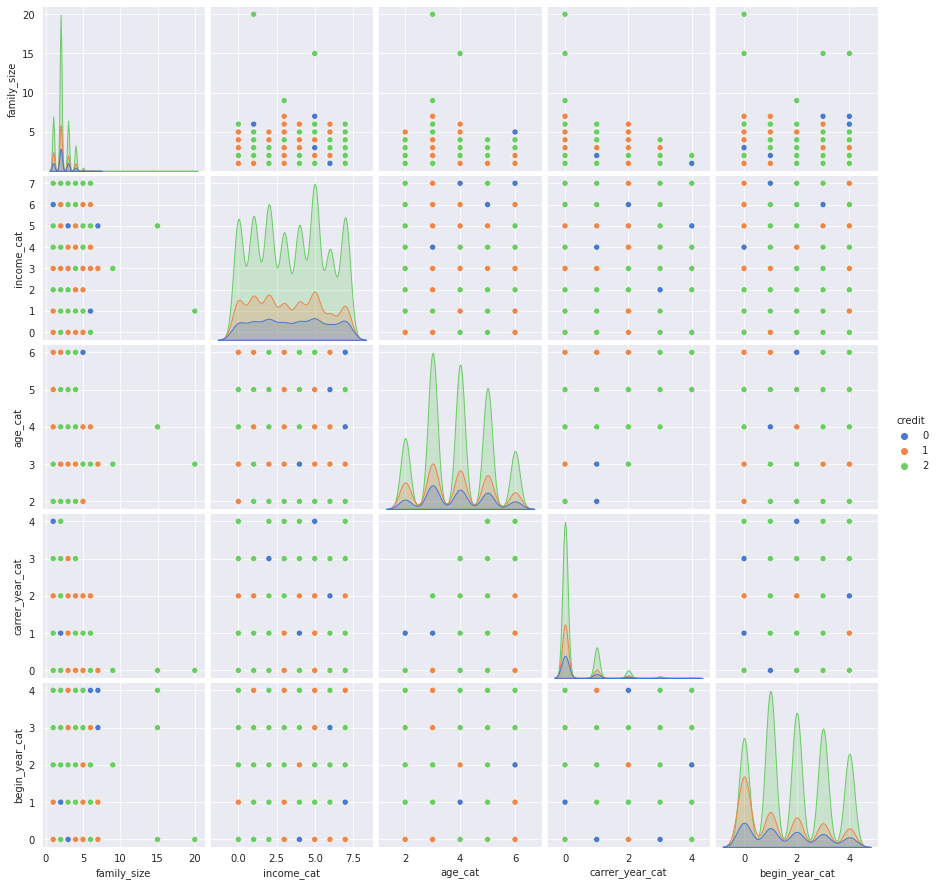

In [87]:
sns.pairplot(data=train_df[['family_size', 'income_cat', 'age_cat', 'carrer_year_cat', 'begin_year_cat', 'credit']], hue='credit',palette='muted')

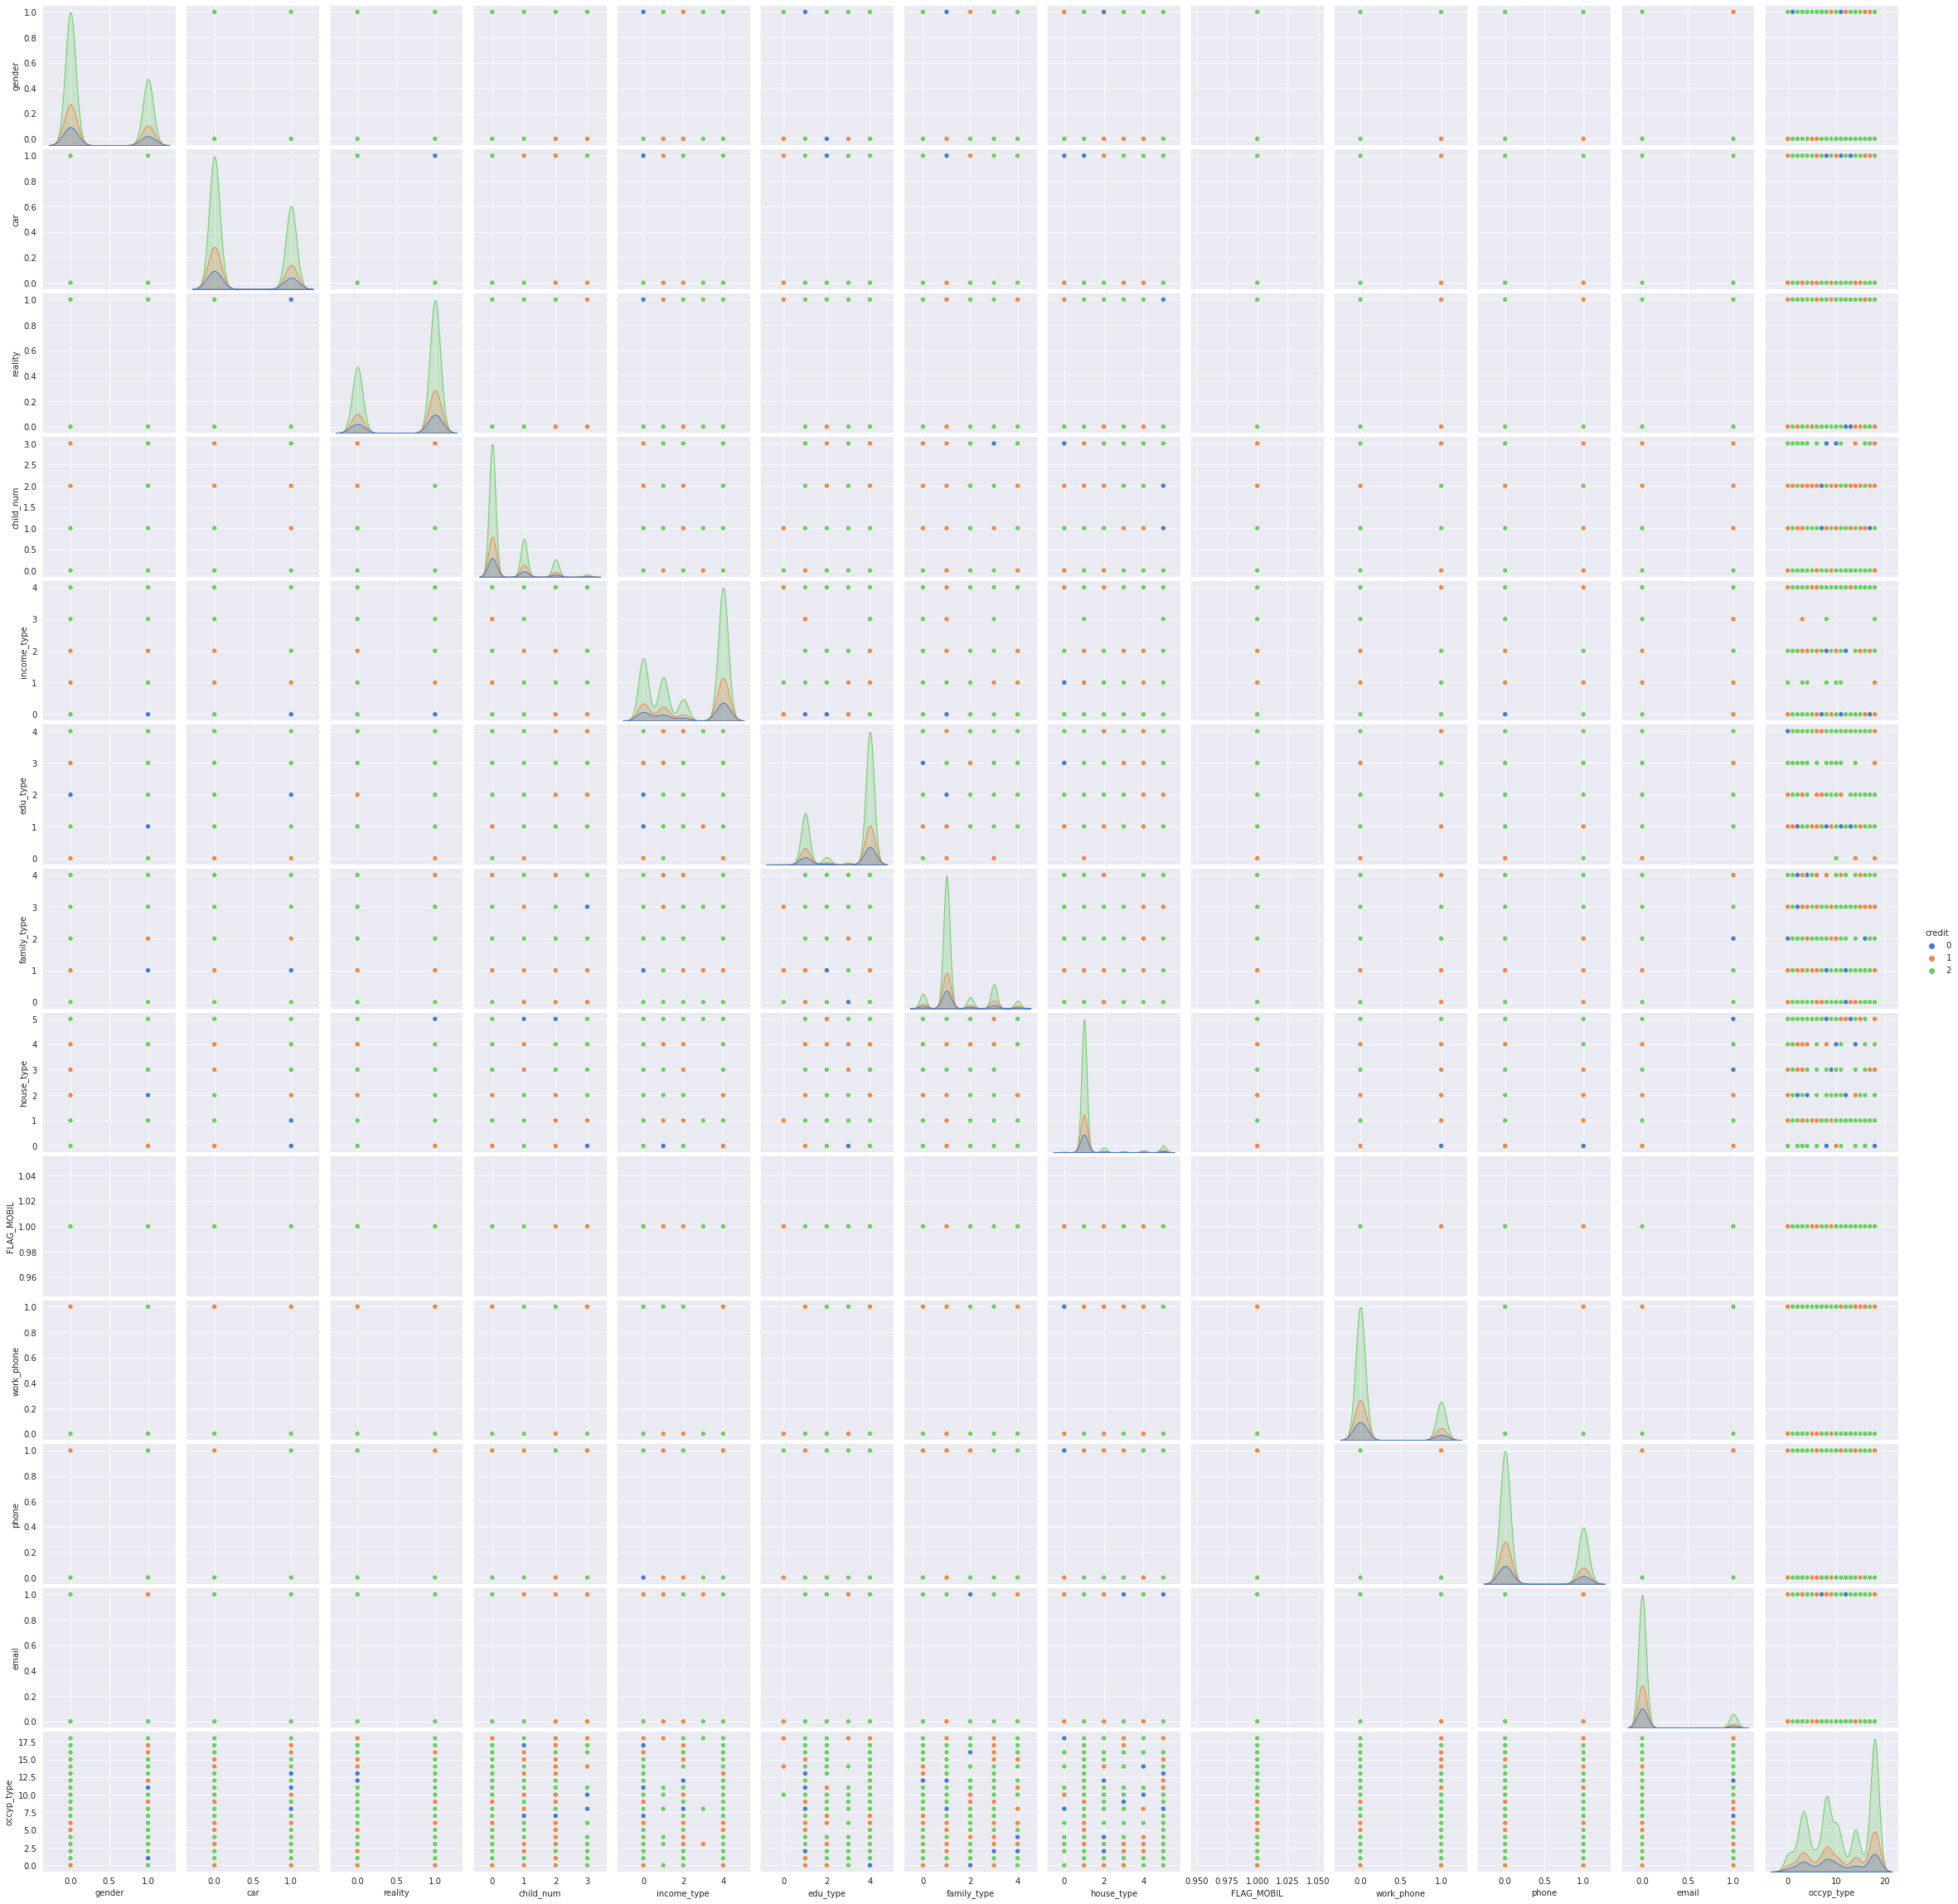

In [88]:
sns.pairplot(data=train_df[['gender','car','reality','child_num','income_type','edu_type','family_type', 'house_type', 'FLAG_MOBIL', 'work_phone','phone','email','occyp_type', 'credit']], hue='credit',palette='muted')

In [89]:
family_type_cat_name

array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
       'Widow'], dtype=object)

In [90]:
pd.crosstab([train_df.gender, train_df.credit], train_df.family_type, margins=True).style.background_gradient(cmap='Pastel2')

In [91]:
house_type_cat_name

array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
       'Office apartment', 'Rented apartment', 'With parents'],
      dtype=object)

In [92]:
pd.crosstab([train_df.gender, train_df.credit], train_df.house_type, margins=True).style.background_gradient(cmap='Pastel2')

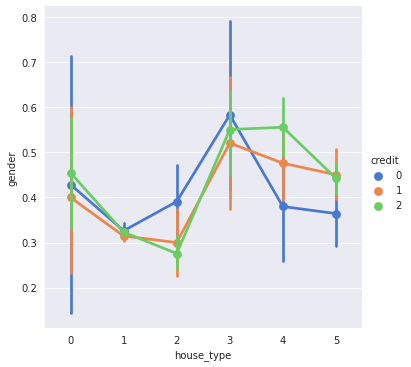

In [93]:
sns.factorplot('house_type','gender',hue='credit',data=train_df)

In [94]:
pd.crosstab([train_df.gender, train_df.credit], train_df.reality, margins=True).style.background_gradient(cmap='Pastel2')

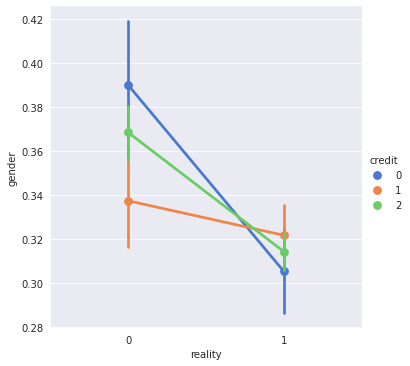

In [95]:
sns.factorplot('reality','gender',hue='credit',data=train_df)

In [96]:
pd.crosstab([train_df.gender, train_df.credit], train_df.income_cat, margins=True).style.background_gradient(cmap='Pastel2')

# Reference
## EDA
* https://www.dacon.io/competitions/official/235713/codeshare/2519?page=1&dtype=view
## Preprocessing
* https://www.dacon.io/competitions/official/235713/codeshare/2475?page=1&dtype=recent